In [1]:
from PIL import Image,  ImageDraw
import numpy as np
import math
import heapq
import matplotlib.pyplot as plt
from Kalman import ekf

In [2]:
import tdmclient.notebook
await tdmclient.notebook.start()

# Global Map 

In [6]:
map = "./img/map2.png"

In [7]:
def convert_image_to_binary_array(image_path,target_size=(1091, 772)):
    # Load the image
    image = Image.open(image_path)

    resized_image = image.resize(target_size)

    # Convert the image to grayscale
    resized_image = resized_image.convert("L")

    # Set the binary threshold
    binary_threshold = 128

    # Convert grayscale to binary image
    bw_image = resized_image.point(lambda p: p < binary_threshold and 1)

    # Convert image to numpy array
    binary_matrix = np.array(bw_image)
    return binary_matrix , resized_image

In [8]:
class NODE:
    def __init__(self, position, g=float('inf'), h=0, parent=None):
        self.position = position
        self.g = g
        self.h = h
        self.f = g + h
        self.parent = parent

    # Nodes will be compared based on their f value, we use this because of the heapq
    def __lt__(self, other):
        return self.f < other.f

    # Function to represent the node
    def __repr__(self):
        return f"Node(position={self.position}, g={self.g}, h={self.h}, f={self.f})"

    @staticmethod
    def reconstruct_path(node):
        path = []
        while node:
            path.append(node.position)
            node = node.parent
        return path[::-1]


# Heuristic function using Octile distance (allowing 8 directions of movement)
def Heuristic_function(node, goal):
    dx = abs(node.position[0] - goal.position[0])
    dy = abs(node.position[1] - goal.position[1])
    return max(dx, dy) + (math.sqrt(2) - 1) * min(dx, dy)

def A_star(environment_map, START_POSITION, GOAL_POSITION):

    START_NODE = NODE(START_POSITION, g=0)
    GOAL_NODE = NODE(GOAL_POSITION)

    START_NODE.h = Heuristic_function(START_NODE, GOAL_NODE)
    START_NODE.f = START_NODE.g + START_NODE.h

    # Initialize the open and closed lists
    OPEN_list = []
    heapq.heappush(OPEN_list, START_NODE)
    CLOSED_set = set()

    # Dictionary to keep track of nodes
    nodes = {}
    nodes[tuple(START_NODE.position)] = START_NODE

    while OPEN_list:
        # Pop the node with the lowest f value
        CURRENT_NODE = heapq.heappop(OPEN_list)

        # If the current node is in the closed set, skip it
        if tuple(CURRENT_NODE.position) in CLOSED_set:
            continue

        # Add the current node's position to the closed set
        CLOSED_set.add(tuple(CURRENT_NODE.position))

        # If the current node is the goal, reconstruct the path
        if CURRENT_NODE.position == GOAL_NODE.position:
            path = NODE.reconstruct_path(CURRENT_NODE)
            print("Path found:", path)
            return path

        # Possible moves: 8 directions (including diagonals)
        MOVES = [[1, 0], [0, 1], [-1, 0], [0, -1],
                 [1, 1], [-1, -1], [1, -1], [-1, 1]]

        # Explore neighbors
        for move in MOVES:
            neighbor_position = [CURRENT_NODE.position[0] + move[0],
                                 CURRENT_NODE.position[1] + move[1]]
            neighbor_pos = tuple(neighbor_position)

            # Skip if out of bounds or obstacle
            if (neighbor_position[0] < 0 or neighbor_position[0] >= environment_map.shape[0] or
                neighbor_position[1] < 0 or neighbor_position[1] >= environment_map.shape[1] or
                environment_map[neighbor_position[0], neighbor_position[1]] == 1):
                continue

            # Skip if in closed set
            if neighbor_pos in CLOSED_set:
                continue

            # Calculate movement cost (diagnoal movement cost is sqrt(2))
            dx = abs(move[0])
            dy = abs(move[1])
            movement_cost = math.sqrt(2) if dx == 1 and dy == 1 else 1

            g_tentative = CURRENT_NODE.g + movement_cost

            # Create or get the neighbor node
            if neighbor_pos not in nodes:
                neighbor_node = NODE(neighbor_position)
                nodes[neighbor_pos] = neighbor_node
            else:
                neighbor_node = nodes[neighbor_pos]

            # If this path to neighbor is better, record it
            if g_tentative < neighbor_node.g:
                neighbor_node.g = g_tentative
                neighbor_node.h = Heuristic_function(neighbor_node, GOAL_NODE)
                neighbor_node.f = neighbor_node.g + neighbor_node.h
                neighbor_node.parent = CURRENT_NODE

                # Add the neighbor to the open list
                heapq.heappush(OPEN_list, neighbor_node)

    print("No path found.")
    return None

In [9]:
binary_matrix , resized_image = convert_image_to_binary_array(map)
# Start and goal positions
START_POSITION = [5, 5]
GOAL_POSITION = [760, 1080]

path = A_star(binary_matrix, START_POSITION, GOAL_POSITION)


Path found: [[5, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [6, 12], [6, 13], [6, 14], [6, 15], [6, 16], [6, 17], [6, 18], [6, 19], [6, 20], [6, 21], [6, 22], [6, 23], [6, 24], [6, 25], [6, 26], [6, 27], [6, 28], [6, 29], [6, 30], [6, 31], [6, 32], [6, 33], [7, 34], [8, 35], [8, 36], [8, 37], [9, 38], [10, 39], [11, 40], [12, 41], [13, 42], [14, 43], [15, 44], [15, 45], [16, 46], [16, 47], [17, 48], [17, 49], [18, 50], [19, 51], [19, 52], [20, 53], [21, 54], [22, 55], [23, 56], [24, 57], [25, 58], [26, 59], [27, 60], [28, 61], [29, 62], [30, 63], [30, 64], [31, 65], [32, 66], [33, 67], [34, 68], [35, 69], [36, 70], [37, 71], [38, 72], [39, 73], [39, 74], [39, 75], [40, 76], [41, 77], [42, 78], [43, 79], [44, 80], [45, 81], [46, 82], [46, 83], [46, 84], [46, 85], [47, 86], [48, 87], [48, 88], [48, 89], [48, 90], [48, 91], [48, 92], [49, 93], [50, 94], [51, 95], [52, 96], [53, 97], [54, 98], [55, 99], [55, 100], [56, 101], [57, 102], [58, 103], [59, 104], [60, 105], [61, 106],

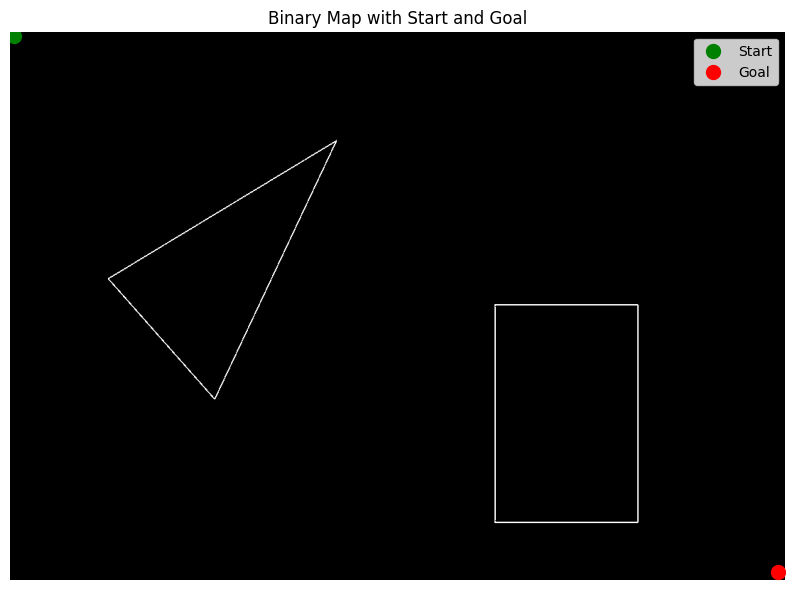

In [10]:
# Display the binary map with start and goal points
plt.figure(figsize=(10, 10))
plt.imshow(binary_matrix, cmap="gray")
plt.scatter(START_POSITION[1], START_POSITION[0], color='green', s=100, label="Start")  # Green for Start
plt.scatter(GOAL_POSITION[1], GOAL_POSITION[0], color='red', s=100, label="Goal")  # Red for Goal
plt.title("Binary Map with Start and Goal")
plt.legend()
plt.axis("off")
plt.show()


PIL and Matplotlib have different systems of coordinates. Pillow treats the top-left corner as (0,0), and coordinates increase downwards and rightwards.While for Matplotlib displays images as NumPy arrays, where the origin is at the bottom-left corner, and the y-axis is flipped compared to Pillow.

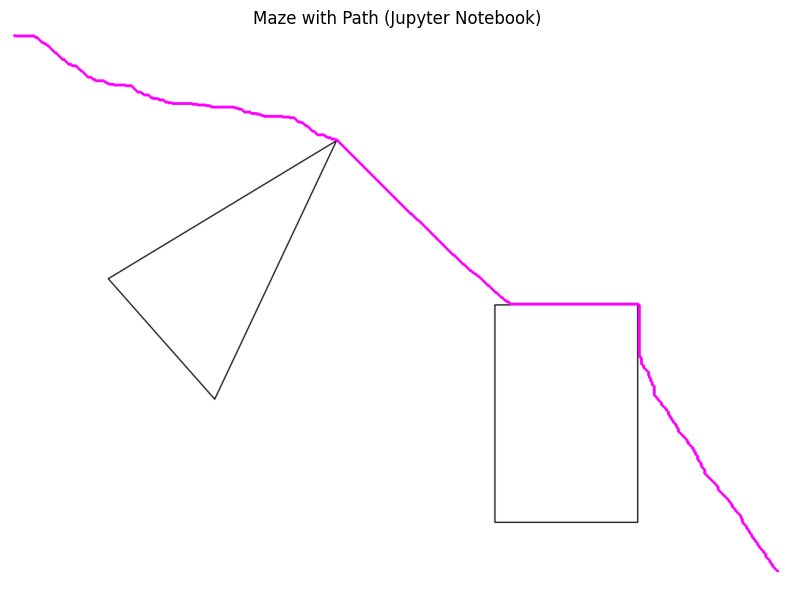

In [11]:
def swap_path_coordinates(path_coordinates):
    swapped_path = [[y, x] for x, y in path_coordinates]
    return swapped_path

def display_path(maze_img, path):

    # Convert the maze image to RGB (to draw in color)
    maze_img = maze_img.convert("RGB")

    # Swap path coordinates to match PIL's (x, y) format
    path = swap_path_coordinates(path)

    # Create a drawing object
    draw = ImageDraw.Draw(maze_img)

    # Draw the path (magenta line)
    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        draw.line((x1, y1, x2, y2), fill=(255, 0, 255), width=4)  # Magenta line with width 4

    # Save the modified image (optional)
    #maze_img.save("maze_with_path_fixed.png")

    # Display the image using Matplotlib
    maze_array = np.array(maze_img)  # Convert to NumPy array for Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(maze_array)
    plt.axis("off")
    plt.title("Maze with Path (Jupyter Notebook)")
    plt.show()

display_path(resized_image, path)

In [12]:
def segment_path(path, step=10):
    """
    Segments the A* path into waypoints for the motion controller.

    Parameters:
    - path: List of (row, column) points from the A* algorithm.
    - step: Number of points to skip between waypoints.

    Returns:
    - waypoints: List of (x, y) waypoints in meters.
    """
    waypoints = path[::step]  # Take every `step`-th point
    waypoints.append(path[-1])  # Ensure the last point (goal) is included
    return waypoints

def grid_to_world_coordinates(waypoints, map_resolution, origin=(0, 0)):
    """
    Converts waypoints from grid coordinates to world coordinates.

    Parameters:
    - waypoints: List of (row, col) waypoints in grid coordinates.
    - map_resolution: Size of each grid cell in meters.
    - origin: World coordinates of the grid's (0, 0).

    Returns:
    - world_waypoints: List of (x, y) waypoints in meters.
    """
    world_waypoints = [
        (origin[0] + w[1] * map_resolution, origin[1] + w[0] * map_resolution) for w in waypoints
    ]
    return world_waypoints


In [13]:
waypoints = segment_path(path, step=40) 
map_resolution = 0.05  
origin = (0, 0)
world_waypoints = grid_to_world_coordinates(waypoints, map_resolution, origin)

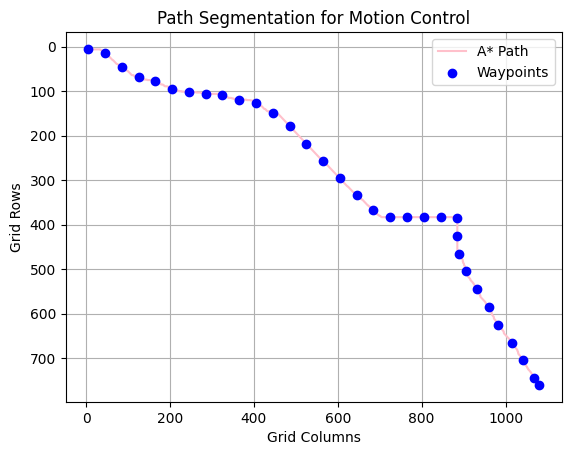

In [14]:
path = np.array(path)
plt.plot(path[:, 1], path[:, 0], label="A* Path", color="pink")

waypoints = np.array(waypoints)
plt.scatter(waypoints[:, 1], waypoints[:, 0], color="blue", label="Waypoints", zorder=3)

plt.gca().invert_yaxis()  
plt.legend()
plt.title("Path Segmentation for Motion Control")
plt.xlabel("Grid Columns")
plt.ylabel("Grid Rows")
plt.grid()
plt.show()


# Motion Control 

## Testing some things on thymio: 

In [3]:
!pip install --upgrade tdmclient

# Astolfi Controller for Robot Motion Control

The **Astolfi controller** is an effective method for controlling the motion of a robot as it navigates through a series of waypoints. It is particularly suited for non-holonomic robots like the Thymio, where motion constraints must be respected. The controller ensures smooth and stable convergence to the desired goal by leveraging a mathematical model based on polar coordinates.

---

## Overview of the Motion Control Function: `move_to_position`

The `move_to_position` function continuously receives the robot's position and orientation from the Vision module and updated goal positions from the Optimal Path module. The robot’s task is to smoothly navigate to each goal, aligning its orientation and position at each step. The Astolfi controller is implemented to achieve this.

### **Inputs to the Function**
1. **Robot's Current State**:
   - \(x, y\): The current position of the robot (from the Vision module).
   - \(\theta\): The robot's current orientation in radians, within \([- \pi, \pi]\).

2. **Goal Position**:
   - \(x_g, y_g\): The continuously updated goal position provided by the Optimal Path module.

---

## How the Astolfi Controller Works

### **1. Error Computation**
The Astolfi controller operates in polar coordinates, where the robot's state relative to the goal is defined by:
- **Distance to the Goal (\(\rho\))**:
  \[
  \rho = \sqrt{(x_g - x)^2 + (y_g - y)^2}
  \]
  This represents the straight-line distance between the robot and the goal.

- **Angle to the Goal (\(\alpha\))**:
  \[
  \alpha = \text{atan2}(y_g - y, x_g - x) - \theta
  \]
  This is the angular error between the robot's heading (\(\theta\)) and the direction to the goal. The angle is normalized to \([- \pi, \pi]\) to avoid discontinuities.

### **2. Control Law**
The controller generates two commands:
- **Linear Velocity (\(v\))**:
  \[
  v = k_\rho \cdot \rho
  \]
  The linear velocity is proportional to the distance to the goal. As the robot approaches the goal (\(\rho \to 0\)), the speed smoothly decreases.

- **Angular Velocity (\(\omega\))**:
  \[
  \omega = k_\alpha \cdot \alpha
  \]
  The angular velocity is proportional to the angular error \(\alpha\), ensuring the robot aligns its orientation toward the goal.

### **3. Wheel Speed Computation**
The linear (\(v\)) and angular (\(\omega\)) velocities are converted into motor commands for the robot's wheels:
\[
v_{\text{left}} = v - \frac{\omega \cdot L}{2}
\]
\[
v_{\text{right}} = v + \frac{\omega \cdot L}{2}
\]
Where:
- \(L\) is the distance between the wheels.

### **4. Stopping Condition**
The robot stops moving when the distance to the goal (\(\rho\)) falls below a small threshold (\(\epsilon\)). This ensures the robot remains stable and does not oscillate around the goal.

---

## Justification for Using the Astolfi Controller

The Astolfi controller is well-suited for this application for several reasons:
1. **Smooth Trajectory Following**:
   - The polar coordinate formulation ensures smooth and natural transitions between waypoints without abrupt changes in speed or direction.

2. **Non-Holonomic Compatibility**:
   - The controller accounts for the kinematic constraints of non-holonomic robots like the Thymio, ensuring feasible motion.

3. **Stability**:
   - The control law is based on a Lyapunov stability analysis, ensuring that the robot converges to the desired goal (\((\rho, \alpha) = (0, 0)\)) with exponential stability.

4. **Dynamic Behavior Near Goals**:
   - The linear velocity (\(v\)) naturally decreases as the robot approaches the goal, preventing overshooting or oscillations. 

5. **Modular Integration**:
   - The controller seamlessly integrates with upstream modules like Vision (for pose estimation) and Optimal Path (for goal updates), allowing for dynamic navigation in real-time.

---

## Summary of the Workflow
1. The Vision module provides the robot’s real-time position \((x, y)\) and orientation (\(\theta\)).
2. The Optimal Path module supplies a series of goal positions \((x_g, y_g)\).
3. The `move_to_position` function computes:
   - The positional error (\(\rho\)) and angular error (\(\alpha\)).
   - Linear and angular velocities (\(v, \omega\)) using the Astolfi controller.
   - Wheel speeds (\(v_{\text{left}}, v_{\text{right}}\)) for the robot's motors.
4. The robot moves toward each goal, adjusting its trajectory dynamically.
5. The robot stops when it reaches the goal, ensuring smooth and accurate navigation.

---

The Astolfi controller provides an elegant and robust solution for trajectory following, ensuring the robot reaches its goals efficiently and stably, even in dynamically changing environments.




In [3]:
# Robot-specific constants
ROBOT_CENTER_TO_WHEEL = 47.5  # Half the wheelbase mm
ROBOT_WHEEL_RADIUS = 22    # Radius of the wheels mm
SPEED_THRESHOLD = 100         # Max Thymio wheel speed

# Normalize angle to (-pi, pi)
def normalize_angle(angle):
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

# Astolfi Controller for Thymio
def astolfi_controller(state, goal, kr= 1.5, ka=  0.5 , goal_tolerance=20):

    x = state[0] #en mm 
    y = state[1] #en mm 
    theta = state[2]
    x_goal, y_goal = goal
    dx = x_goal - x
    dy = y_goal - y
    rho = np.sqrt(dx**2 + dy**2)  # Distance to goal

    print ("Distance to goal = " , rho )

    alpha = normalize_angle(np.arctan2(dy, dx) - theta)

    # Stop if the robot is close enough to the goal
    if rho < goal_tolerance:
        return 0.0, 0.0, True
    # Control laws
    v = kr * rho #kr > 0 
    #v = max(kr * rho, MIN_SPEED) 
    omega = ka * alpha 
    return v, omega, False


# Convert velocities to motor speeds
def compute_motor_speeds(v, omega):

    # Convert speed thresholds for clipping
    max_v = SPEED_THRESHOLD * 0.388  # Max linear velocity in mm/s
    max_omega = max_v / ROBOT_CENTER_TO_WHEEL  # Max angular velocity in rad/s

    v = np.clip(v, -max_v, max_v) #actul control velocity given to the thymio 
    omega = np.clip(omega, -max_omega, max_omega)

    right_wheel_mm_s = (v + omega * ROBOT_CENTER_TO_WHEEL)  # mm/s
    left_wheel_mm_s = (v - omega * ROBOT_CENTER_TO_WHEEL)  # mm/s

    thymio_speed_to_mms = 0.388
    right_wheel_enc = np.clip(right_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)
    left_wheel_enc = np.clip(left_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)

    # Debugging outputs
    print(f"Clipped control inputs: v = {v}, omega = {omega}")
    print(f"left wheel control speed = {left_wheel_enc}, right wheel control speed = {right_wheel_enc}")

    return int(left_wheel_enc), int(right_wheel_enc) , v , omega 


## TEST 

In [4]:
#fonctions de Julie 
@tdmclient.notebook.sync_var 
def set_speed(right_speed,left_speed):
    global motor_right_target, motor_left_target
    motor_right_target=right_speed
    motor_left_target=left_speed

@tdmclient.notebook.sync_var
def stop_thymio():
    global motor_right_target,motor_left_target
    motor_right_target=0
    motor_left_target=0

@tdmclient.notebook.sync_var
def get_speed():
    global motor_right_speed, motor_left_speed
    return motor_right_speed,motor_left_speed

def speed_convesion(r_speed,l_speed):
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation

    #odometry 
    avg_thymio_speed = (r_speed + l_speed) / 2
    speed = avg_thymio_speed * thymio_speed_to_mms # [mm/s]
    return speed

def angular_vel_conversion(r_speed,l_speed):
    d = 95 # distance between the 2 wheels [mm]
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation
    
    difference_speed = l_speed - r_speed
    omega = difference_speed * thymio_speed_to_mms / d # [rad/s]

    return omega


In [5]:
def move_to_waypoint(state, waypoint, goal_tolerance=20):
    # Astolfi controller to compute control signals
    v, omega, reached = astolfi_controller(state, waypoint, goal_tolerance=goal_tolerance)
    if reached:
        return 0, 0, True , 0 ,0
    # Convert control signals to motor speeds
    left_speed, right_speed ,v_f , omega_f = compute_motor_speeds(v, omega)
    return left_speed, right_speed, False , v_f , omega_f  #in Thymio's units 


In [ ]:
"""  
notre premiere version mais jpense que mettre move to waypoint en premier serait mieux!! 
while not reached:
        # Get current odometry data
        r_speed, l_speed = get_speed()
        print(f"Actual Speeds: r_speed = {r_speed}, l_speed = {l_speed}")
        actual_v = speed_convesion(r_speed, l_speed)
        actual_w = angular_vel_conversion(r_speed, l_speed)
        obs_odometry = np.array([actual_v, actual_w])
        #Print odometry data
        print(f"Odometry: v = {actual_v}, w = {actual_w}")

        # Move towards the waypoint
        input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(state_est, waypoint, goal_tolerance)

        set_speed(input_right_speed, input_left_speed)

        # Control input
        input_v = v_f
        input_w = omega_f
        control_vect_prev = np.array([input_v, input_w])

        # Print control inputs
        print(f"Control Inputs: v = {input_v}, w = {input_w}")

        # Update state with Kalman filter
        state_est, P_est = ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state)
        # Print updated state
        print(f"Position Actuelle odometry: x = {state_est[0]}, y = {state_est[1]}, theta = {state_est[2]}")

        """


In [19]:
#pour tester
waypoints = [(0, 600) ]  

# Initial state [x, y, theta]
state_est=[0,0,0,0,0] 
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_tolerance = 50

obs_camera=[np.nan,np.nan,np.nan]
camera_state=False

# Start motion
for waypoint in waypoints:
    print("Goal" , waypoint)
    reached = False
    while not reached:

        # Move towards the waypoint
        input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(state_est, waypoint, goal_tolerance)

        set_speed(input_right_speed, input_left_speed)
        # Get current odometry data
        r_speed, l_speed = get_speed()
        print(f"Actual Speeds: r_speed = {r_speed}, l_speed = {l_speed}")
        actual_v = speed_convesion(r_speed, l_speed)
        actual_w = angular_vel_conversion(r_speed, l_speed)
        obs_odometry = np.array([actual_v, actual_w])
        #Print odometry data
        print(f"Odometry: v = {actual_v}, w = {actual_w}")


        # Control input
        input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
        input_w = omega_f
        control_vect_prev = np.array([input_v, input_w])

        # Print control inputs
        print(f"Control Inputs: v = {input_v}, w = {input_w}")

        # Update state with Kalman filter
        state_est, P_est = ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state)
        # Print updated state
        print(f"Position Actuelle odometry: x = {state_est[0]}, y = {state_est[1]}, theta = {state_est[2]}") 


    # Stop the robot at the waypoint
    stop_thymio()
    print(f"Reached waypoint: {waypoint}")

print("Trajectory completed!")


Goal (0, 600)
Actual Speeds: r_speed = 0, l_speed = -5
Odometry: v = -0.8, w = -0.016842105263157894
Distance to goal =  600.0
Clipped control inputs: v = 32.0, omega = 0.6736842105263158
left wheel control speed = 0.0, right wheel control speed = 100.0
Control Inputs: v = 32.0, w = 0.6736842105263158
Position Actuelle odometry: x = 3.1804529201430274, y = 0.0, theta = 0.0030736058022150237
Actual Speeds: r_speed = 0, l_speed = -5
Odometry: v = -0.8, w = -0.016842105263157894
Distance to goal =  600.0084293414362
Clipped control inputs: v = 32.0, omega = 0.6736842105263158
left wheel control speed = 0.0, right wheel control speed = 100.0
Control Inputs: v = 32.0, w = 0.6736842105263158
Position Actuelle odometry: x = 5.713720824720048, y = -0.06156787299171371, theta = 0.02627869544941
Actual Speeds: r_speed = 0, l_speed = -5
Odometry: v = -0.8, w = -0.016842105263157894
Distance to goal =  600.0887699697903
Clipped control inputs: v = 32.0, omega = 0.6736842105263158
left wheel contro

In [16]:
stop_thymio()